In [54]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [55]:
data = pd.read_csv('pitcher_subset.csv')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149070 entries, 0 to 149069
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   gameid            149070 non-null  object 
 1   GameDate          149070 non-null  object 
 2   ab                149070 non-null  int64  
 3   pitchnum          149070 non-null  int64  
 4   inning            149070 non-null  float64
 5   teambat           149070 non-null  int64  
 6   balls             149070 non-null  float64
 7   strikes           149070 non-null  float64
 8   outs              149070 non-null  float64
 9   pitcher           149070 non-null  object 
 10  pitcherthrows     149070 non-null  object 
 11  batter            149070 non-null  object 
 12  batterside        149070 non-null  object 
 13  pitchresult       149070 non-null  object 
 14  pitchresult_desc  149070 non-null  object 
 15  eventtype         149070 non-null  object 
 16  pitchname         14

In [57]:
data['score_diff'] = np.where(data['teambat'] == 0, data['homscore'] - data['visscore'], data['visscore'] - data['homscore'])
data['pitch_type'] = data['pitch_type'].map({'Breaking Ball': 0, 'Fastball':1})
data['prev_pitch'] = data['pitch_type'].shift(-1)

In [58]:
data['GameDate'] = pd.to_datetime(data['GameDate'])
data.sort_values('GameDate')

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,pitcher,...,venue_name,year,visscore,homscore,r1bool,r2bool,r3bool,pitch_type,score_diff,prev_pitch
103303,2021/04/01/tormlb-nyamlb-1,2021-04-01 12:05:00,65,6,9.0,0,1.0,2.0,0.0,"O'Day, Darren",...,Yankee Stadium,2021,2.0,2.0,0.0,0.0,0.0,1,0.0,0.0
103323,2021/04/01/tormlb-nyamlb-1,2021-04-01 12:05:00,69,3,9.0,1,1.0,1.0,0.0,"Romano, Jordan",...,Yankee Stadium,2021,2.0,2.0,0.0,0.0,0.0,1,0.0,0.0
103322,2021/04/01/tormlb-nyamlb-1,2021-04-01 12:05:00,69,2,9.0,1,1.0,0.0,0.0,"Romano, Jordan",...,Yankee Stadium,2021,2.0,2.0,0.0,0.0,0.0,1,0.0,1.0
103321,2021/04/01/tormlb-nyamlb-1,2021-04-01 12:05:00,69,1,9.0,1,0.0,0.0,0.0,"Romano, Jordan",...,Yankee Stadium,2021,2.0,2.0,0.0,0.0,0.0,0,0.0,1.0
103320,2021/04/01/tormlb-nyamlb-1,2021-04-01 12:05:00,68,4,9.0,0,1.0,2.0,2.0,"O'Day, Darren",...,Yankee Stadium,2021,2.0,2.0,1.0,0.0,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39848,2023/10/01/wasmlb-atlmlb-1,2023-10-01 19:10:00,80,1,9.0,0,0.0,0.0,0.0,"Tonkin, Michael",...,Truist Park,2023,7.0,8.0,0.0,0.0,0.0,0,1.0,1.0
39847,2023/10/01/wasmlb-atlmlb-1,2023-10-01 19:10:00,80,2,9.0,0,1.0,0.0,0.0,"Tonkin, Michael",...,Truist Park,2023,7.0,8.0,0.0,0.0,0.0,0,1.0,0.0
39846,2023/10/01/wasmlb-atlmlb-1,2023-10-01 19:10:00,80,3,9.0,0,1.0,1.0,0.0,"Tonkin, Michael",...,Truist Park,2023,7.0,8.0,0.0,0.0,0.0,1,1.0,0.0
33294,2023/10/01/minmlb-colmlb-1,2023-10-01 19:10:00,56,1,8.0,0,0.0,0.0,1.0,"Lawrence, Justin",...,Coors Field,2023,2.0,1.0,0.0,0.0,0.0,1,-1.0,1.0


In [59]:
subset = data[['pitcher', 'GameDate', 'balls', 'strikes', 'outs', 'pitcherthrows', 'batterside', 'r1bool', 'r2bool', 'r3bool', 'pitch_type', 'score_diff', 'prev_pitch']].copy()

In [60]:
historic_fastball_rate = subset.groupby('pitcher')['pitch_type'].mean().reset_index()
historic_fastball_rate.columns = ['pitcher', 'historic_rate']
subset = pd.merge(subset, historic_fastball_rate, on ='pitcher')
#subset = subset.drop('pitcher', axis=1)

In [61]:
subset['in_scoring_position'] = subset[['r2bool', 'r3bool']].max(axis=1)

In [62]:
subset['balls_strikes'] = subset['balls'].astype(int).astype(str) + '_' + subset['strikes'].astype(int).astype(str)
subset.loc[subset['batterside'] == subset['pitcherthrows'], 'platoon_same'] = 1.0
subset.loc[subset['batterside'] != subset['pitcherthrows'], 'platoon_same'] = 0.0

In [63]:
one_hot_df = pd.get_dummies(subset['balls_strikes'], prefix='Count', dtype=int)
subset = pd.concat([subset, one_hot_df], axis=1)

In [64]:
subset['pitcher_count'] = subset[['Count_1_2', 'Count_0_2', 'Count_2_2']].max(axis=1)
subset['small_pitcher_count'] = subset[['Count_1_1', 'Count_0_1']].max(axis=1)
subset['mid_count'] = subset[['Count_0_0', 'Count_1_0', 'Count_2_1', 'Count_3_2']].max(axis=1)
subset['small_batter_count'] = subset[['Count_2_0', 'Count_3_1']].max(axis=1)
subset['batter_count'] = subset['Count_3_0']

In [65]:
subset['outs_pc_interaction'] = subset['outs'] * subset['pitcher_count']
subset['outs_spc_interaction'] = subset['outs'] * subset['small_pitcher_count']
subset['outs_mc_interaction'] = subset['outs'] * subset['mid_count']
subset['outs_sbc_interaction'] = subset['outs'] * subset['small_batter_count']
subset['outs_bc_interaction'] = subset['outs'] * subset['batter_count']


In [67]:
log_reg_df = subset[['GameDate', 'pitch_type', 'platoon_same', 'in_scoring_position', 'pitcher_count', 'small_pitcher_count', 'mid_count',
                      'small_batter_count', 'batter_count', 'outs', 'score_diff', 'outs_pc_interaction', 'outs_spc_interaction',
                        'outs_mc_interaction', 'outs_sbc_interaction', 'outs_bc_interaction', 'historic_rate', 'prev_pitch']]

log_reg_df = log_reg_df.dropna()

In [87]:
train = log_reg_df[log_reg_df['GameDate'] < '2023-06-15']
X_train = train.drop(['pitch_type', 'GameDate'], axis=1)
y_train = train[['pitch_type']]

test = log_reg_df[log_reg_df['GameDate'] >= '2023-06-15']
X_test = test.drop(['pitch_type', 'GameDate'], axis=1)
y_test = test[['pitch_type']]

In [88]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


# Create and fit the logistic regression model
model = sm.Logit(y_train, X_train)
result = model.fit()

print(result.summary())
# Predict on the test set
y_plot = result.predict(X_train)
y_pred_prob = result.predict(X_test)
y_pred = (y_pred_prob >= 0.6).astype(int)
# Calculate and print the accuracy of the model
#accuracy = accuracy_score(y_test, y_pred)
#print(f'Accuracy: {accuracy:.2f}')

Optimization terminated successfully.
         Current function value: 0.594243
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             pitch_type   No. Observations:               120826
Model:                          Logit   Df Residuals:                   120809
Method:                           MLE   Df Model:                           16
Date:                Tue, 15 Oct 2024   Pseudo R-squ.:                  0.1222
Time:                        14:47:15   Log-Likelihood:                -71800.
converged:                       True   LL-Null:                       -81800.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.2945        nan        nan        nan         nan         nan

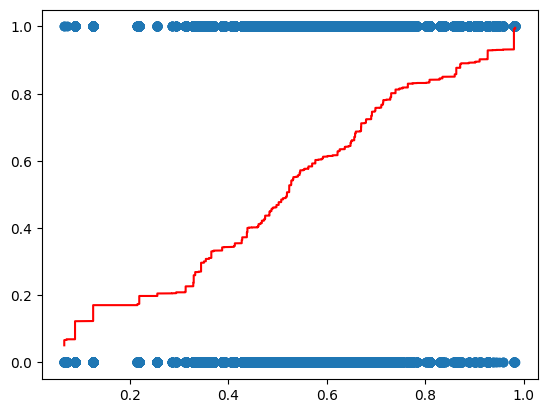

In [89]:
plt.scatter(X_train['historic_rate'], y_train)
plt.plot(X_train['historic_rate'].sort_values(), y_plot.sort_values(), color='red', label='Logistic Regression Line')

In [90]:
from sklearn import metrics
from sklearn.metrics import classification_report

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
target_names = ['breaking ball', 'fastball']
print(classification_report(y_test, y_pred, target_names=target_names))
cnf_matrix

               precision    recall  f1-score   support

breaking ball       0.55      0.76      0.64     11749
     fastball       0.77      0.57      0.65     16494

     accuracy                           0.65     28243
    macro avg       0.66      0.66      0.65     28243
 weighted avg       0.68      0.65      0.65     28243



array([[8876, 2873],
       [7129, 9365]])

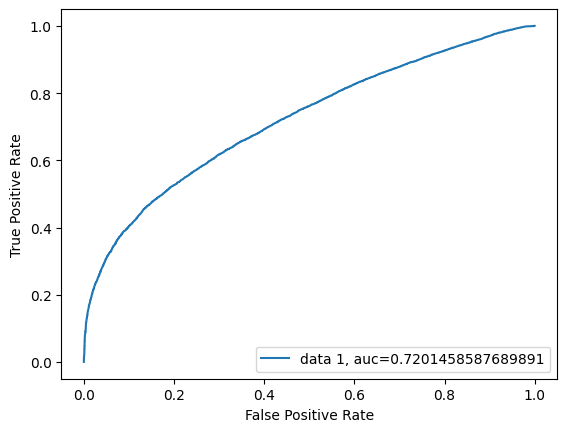

In [91]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()